In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [35]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import functional as F
import cv2
import xml.etree.ElementTree as ET
from PIL import Image

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

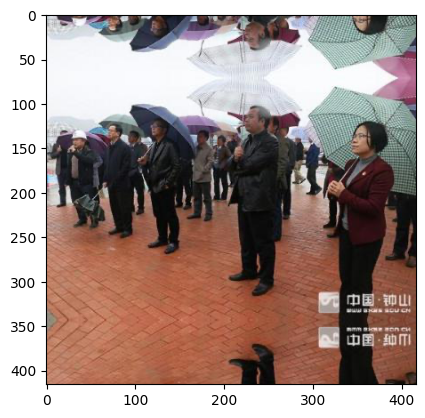

In [37]:
img = cv2.imread('/kaggle/input/hard-hat-detection/images/hard_hat_workers1006.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [38]:
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

def visualize_single(image_path, xml_path):
    # Parse XML
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image, name, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Display
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# # 🧪 Example usage
# visualize_single("images/image1.jpg", "annotations/image1.xml")


In [39]:
img_path = '/kaggle/input/hard-hat-detection/images/hard_hat_workers1005.png'
ann_path = '/kaggle/input/hard-hat-detection/annotations/hard_hat_workers1005.xml'

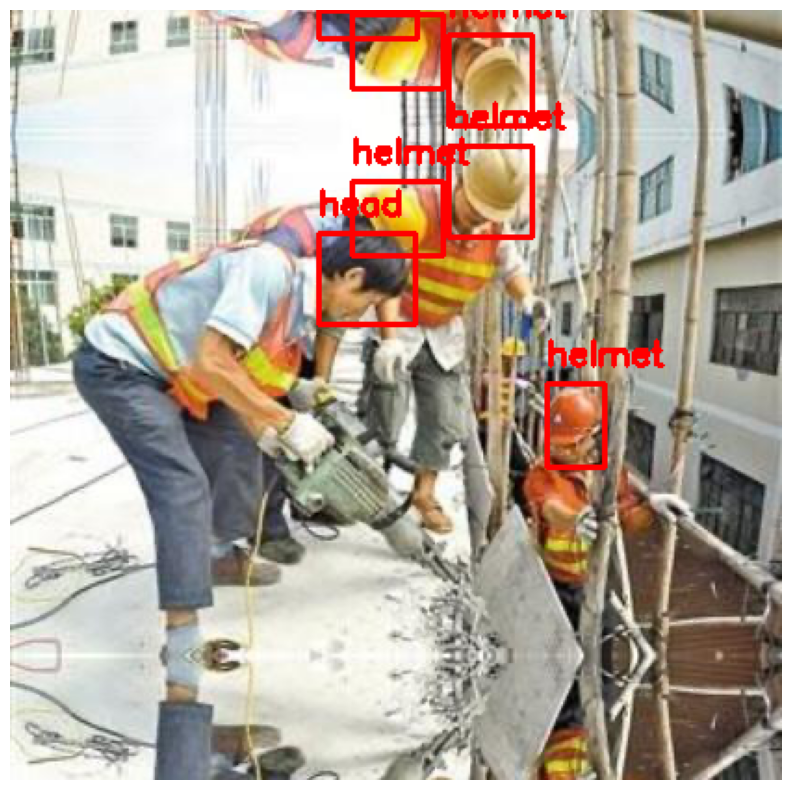

In [40]:
visualize_single(img_path,ann_path)

In [41]:
import os
import random
from sklearn.model_selection import train_test_split

def split_data(image_dir,test_size=0.2,seed=42):
    image_files = sorted(os.listdir(image_dir))
    train_imgs, test_imgs = train_test_split(image_files, test_size=test_size, random_state=seed)
    return train_imgs, test_imgs

In [42]:
#From this we get names of files - img and annotations have same names except for extension
train_files,test_files = split_data('/kaggle/input/hard-hat-detection/images')

In [82]:
class CustomDataset(Dataset):
    def __init__(self,image_dir,annotation_dir,file_list,transforms=None,label_map=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.file_list = file_list
        self.label_map = label_map or {}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self,idx):
        filename = self.file_list[idx]
        img_path = os.path.join(self.image_dir,filename)
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)  # Convert PIL to np.array before Albumentations

        xml_file = filename.replace(".png", ".xml")
        xml_path = os.path.join(self.annotation_dir, xml_file)
        boxes, labels = self.parse_voc_xml(xml_path)
        # Albumentations expects boxes as list of [xmin, ymin, xmax, ymax]
        transformed = self.transforms(
            image=image,
            bboxes=boxes,
            category_ids=labels
        )
    
        image = transformed['image']
        boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
        labels = torch.tensor(transformed['category_ids'], dtype=torch.int64)
    
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }
    
        return image, target
        # Uncomment this if you don't use Albumentations
        # boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # labels = torch.as_tensor(labels, dtype=torch.int64)

        # target = {
        #     "boxes": boxes,
        #     "labels": labels,
        #     "image_id": torch.tensor([idx])
        # }

        # if self.transforms:
        #     image = self.transforms(image)

        # return image, target

    def parse_voc_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.label_map.get(name, 0))
        return boxes, labels

In [83]:
label_map = {'head': 1, 'helmet': 2}
img_dir = '/kaggle/input/hard-hat-detection/images'
ann_dir = '/kaggle/input/hard-hat-detection/annotations'

# transform = transforms.Compose([
#     # transforms.Resize((300, 300)),  # Resize all images to 300x300
#     transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
# ])
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(300, 300),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.3),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))



In [84]:
train_dataset = CustomDataset(img_dir,ann_dir,train_files,transform,label_map) #order matters

In [85]:
train_dataset[0]

(tensor([[[105, 119, 120,  ..., 207, 200, 210],
          [103, 113, 115,  ..., 203, 198, 209],
          [108, 106, 104,  ..., 201, 198, 207],
          ...,
          [ 76, 138, 111,  ..., 100, 100, 122],
          [ 57,  45,  82,  ..., 124, 115, 121],
          [103,  93, 126,  ..., 133, 116, 134]],
 
         [[ 93, 107, 110,  ..., 207, 200, 211],
          [ 93, 101, 104,  ..., 202, 198, 209],
          [ 96,  95,  92,  ..., 201, 197, 206],
          ...,
          [ 67, 129, 104,  ..., 116, 115, 137],
          [ 52,  39,  76,  ..., 142, 132, 139],
          [ 98,  88, 120,  ..., 150, 136, 153]],
 
         [[ 93, 107, 110,  ..., 201, 195, 206],
          [ 92, 102, 104,  ..., 198, 193, 203],
          [ 96,  95,  92,  ..., 196, 193, 201],
          ...,
          [ 72, 133, 105,  ..., 125, 125, 149],
          [ 56,  44,  80,  ..., 152, 143, 151],
          [106,  96, 129,  ..., 161, 146, 166]]], dtype=torch.uint8),
 {'boxes': tensor([[194.7115, 109.1566, 209.1346, 128.6747],
  

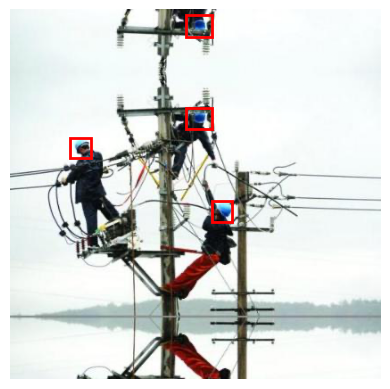

In [76]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import matplotlib.patches as patches

# Get one sample from dataset
img_tensor, target = train_dataset[110]

# Convert tensor to PIL image for visualization (if needed)
# Or directly use matplotlib after permuting dimensions
img = img_tensor.permute(1, 2, 0).numpy()  # Convert [C, H, W] to [H, W, C]

# Plot image
fig, ax = plt.subplots(1)
ax.imshow(img)

# Plot bounding boxes
for box in target['boxes']:
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.axis('off')
plt.show()
